### Some extra imports

In [1]:
%load_ext autoreload
%autoreload 2
from assignment import const
import random
from assignment.pipeline import init_random_seed
from torch.utils.tensorboard import SummaryWriter

## Assignment 2.4: Text classification via CNN (20 points)

In this assignment you should perform sentiment analysis of the IMDB reviews based on CNN architecture. Read carefully [Convolutional Neural Networks for Sentence Classification](https://arxiv.org/pdf/1408.5882.pdf) by Yoon Kim.

In [2]:
import torch

from torchtext import datasets
from torchtext.data import Field, LabelField
from torchtext.data import Iterator

import torch.nn as nn
import torch.optim as optim

### Good idea to froze some randomness before experiments


### Preparing Data

In [44]:
TEXT = Field(sequential=True, lower=True, batch_first=True)
LABEL = LabelField(batch_first=True, dtype=torch.float)

In [45]:

train, tst = datasets.IMDB.splits(TEXT, LABEL)
trn, vld = train.split(random_state=random.seed(const.SEED))

In [46]:
# %%time
TEXT.build_vocab(trn)

In [47]:
LABEL.build_vocab(trn)

### Creating the Iterator (2 points)

Define an iterator here

In [48]:
init_random_seed()
train_iter, val_iter, test_iter = Iterator.splits(
        (trn, vld, tst),
        batch_sizes=(64, 64, 64),
        device='cuda',
        repeat=False,
)

In [49]:
# next(train_iter)

### Define CNN-based text classification model (8 points)

In [63]:
from assignment.model import CNN

In [51]:
kernel_sizes = [3, 4, 5]
vocab_size = len(TEXT.vocab)
dropout = 0.5
dim = 300

model = CNN(vocab_size, dim, kernel_sizes, dropout)

In [52]:
model.cuda()

CNN(
  (emb): Embedding(201009, 300, padding_idx=1)
  (cnns): ModuleList(
    (0): Sequential(
      (0): Conv1d(300, 5, kernel_size=(3,), stride=(1,))
      (1): AdaptiveMaxPool1d(output_size=1)
    )
    (1): Sequential(
      (0): Conv1d(300, 5, kernel_size=(4,), stride=(1,))
      (1): AdaptiveMaxPool1d(output_size=1)
    )
    (2): Sequential(
      (0): Conv1d(300, 5, kernel_size=(5,), stride=(1,))
      (1): AdaptiveMaxPool1d(output_size=1)
    )
  )
  (decoder): Linear(in_features=15, out_features=1, bias=True)
)

### The training loop (3 points)

Define the optimization function and the loss functions.

In [53]:
opt = optim.Adam(params=model.parameters(), lr=1e-3)
loss_func = nn.BCEWithLogitsLoss()

Think carefully about the stopping criteria. 

In [54]:
epochs = 6# your code goes here

In [55]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.display import clear_output

from assignment.util import binary_accuracy

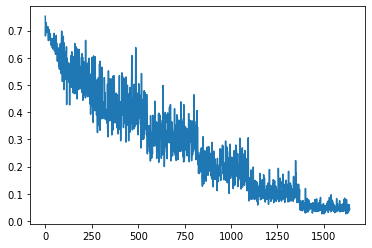

Epoch: 6, Training Loss: 0.050301448727556826, Validation Loss: 0.46390817718485655, Accuracy: 0.8103371858596802
Wall time: 2min 38s


In [56]:
%%time
tb_writer = SummaryWriter('runs/task4/baseline')
init_random_seed()
history = []
for epoch in range(1, epochs + 1):
    running_loss = 0.0
    running_corrects = 0
    model.train()
    for id_batch, batch in enumerate(train_iter):

        x = batch.text
        y = batch.label

        opt.zero_grad()
        preds, _ = model(x)
        loss = loss_func(preds, y)
        loss.backward()
        opt.step()
        running_loss += loss.item()

        tb_writer.add_scalar('Loss/Train', loss.item(), epoch * len(train_iter) + id_batch)


        # visualizing training process
        history.append(loss.item())
        i = 0
        if (id_batch + 1) % 10 == 0:
            i+=1
            clear_output(True)
            plt.plot(history, label='Loss')
            plt.show()

    epoch_loss = running_loss / len(train_iter)

    val_loss = 0.0
    val_acc = 0.0
    model.eval()
    for batch in val_iter:

        x = batch.text
        y = batch.label

        preds, _ = model(x)
        loss = loss_func(preds, y)
        val_loss += loss.item()

        val_acc += binary_accuracy(preds, y)

    val_loss /= len(val_iter)
    val_acc /= len(val_iter)
    tb_writer.add_scalar('Loss/Valid', val_loss, (1 + epoch) * len(train_iter))
    tb_writer.add_scalar('Accuracy/Valid', val_acc, (1 + epoch) * len(train_iter))
    print('Epoch: {}, Training Loss: {}, Validation Loss: {}, Accuracy: {}'.format(epoch, epoch_loss, val_loss, val_acc))
tb_writer.close()

### Calculate performance of the trained model (2 points)

In [64]:
from assignment.pipeline import model_performance_calculator

model_performance_calculator(model, test_iter)

Write down the calculated performance

### Accuracy: 0.8123599886894226
### Precision: 0.8208308815956116
### Recall: 0.7887200117111206
### F1: 0.8044551014900208

### Experiments (5 points)

Experiment with the model and achieve better results. Implement and describe your experiments in details, mention what was helpful.


### 1. Num filters, emb_size tuning (was helpful)
#### Accuracy: 0.8519600033760071
#### Precision: 0.8536291122436523
#### Recall: 0.8496000170707703
#### F1: 0.8516097664833069
<img src="./img/t4_exp1.png">

### 2. Data preprocessing + tuning params (was helpful)
#### Accuracy: 0.876039981842041
#### Precision: 0.8713755011558533
#### Recall: 0.882319986820221
#### F1: 0.8768135905265808

### 3. Pretrained Vectors (was helpful)
#### Accuracy: 0.8926799893379211
#### Precision: 0.9207887053489685
#### Recall: 0.859279990196228
#### F1: 0.8889716863632202

## Experiment 1

In [69]:
import optuna
from optuna.samplers import TPESampler

sampler = TPESampler(seed=const.SEED)
study = optuna.create_study(study_name='task4_num_filters', storage='sqlite:///./.data/optuna_task4.db', load_if_exists=True)

[I 2020-03-30 19:53:39,908] Using an existing study with name 'task4_num_filters' instead of creating a new one.


In [70]:
from assignment import pipeline as rhl_pipeline

In [ ]:
def objective_tune1(trial):
    tb_writer = SummaryWriter(f'runs/task4/optuna/tune1{trial.number}')
    init_random_seed()
    criterion = nn.BCEWithLogitsLoss().cuda()

    num_filters = trial.suggest_int('num_filters', 3, 100)
    emb_dim = trial.suggest_int('emb_dim', 100, 200)

    model = CNN(
        emb_dim = emb_dim,
        num_filters = num_filters,
        vocab_size = len(TEXT.vocab),
        kernel_sizes = [3, 4, 5],
    )

    best_val_loss, _ = rhl_pipeline.train_eval_loop(
        debug=False,
        model=model,
        criterion=criterion,
        epoch_n=50,
        early_stopping_patience=3,
        dataset_train=train_iter,
        dataset_val=val_iter,
        dataloader=lambda batches, *args, **kvargs: batches,
        shuffle_train=False,
        writer=tb_writer,
    )

    tb_writer.add_hparams({'num_filters': num_filters, 'emb_dim': emb_dim}, {'hparam/val_loss': best_val_loss})

    tb_writer.close()
    return best_val_loss

In [65]:
study.optimize(objective_tune1, n_trials=20, n_jobs=1)

[I 2020-03-29 22:21:52,323] Finished trial#4 resulted in value: 0.3989503326810012. Current best value is 0.3989503326810012 with parameters: {'emb_dim': 102, 'num_filters': 12}.
[I 2020-03-29 22:23:35,633] Finished trial#5 resulted in value: 0.36334138212062544. Current best value is 0.36334138212062544 with parameters: {'emb_dim': 111, 'num_filters': 48}.
[I 2020-03-29 22:26:47,649] Finished trial#6 resulted in value: 0.3422600854251344. Current best value is 0.3422600854251344 with parameters: {'emb_dim': 171, 'num_filters': 95}.
[I 2020-03-29 22:28:40,251] Finished trial#7 resulted in value: 0.3605074766328779. Current best value is 0.3422600854251344 with parameters: {'emb_dim': 171, 'num_filters': 95}.
[I 2020-03-29 22:31:07,926] Finished trial#8 resulted in value: 0.33438343516850877. Current best value is 0.33438343516850877 with parameters: {'emb_dim': 123, 'num_filters': 80}.
[I 2020-03-29 22:33:22,105] Finished trial#9 resulted in value: 0.34816334068270055. Current best val

In [66]:
study.best_params, study.best_value
# ({'emb_dim': 173, 'num_filters': 63}, 0.333069981533592)

({'emb_dim': 173, 'num_filters': 63}, 0.333069981533592)

### Model with good params

In [67]:
tb_writer = SummaryWriter(f'runs/task4/optuna/baseline_tuned')
init_random_seed()
criterion = nn.BCEWithLogitsLoss().cuda()

num_filters = 173
emb_dim = 63

model = CNN(
    emb_dim = emb_dim,
    num_filters = num_filters,
    vocab_size = len(TEXT.vocab),
    kernel_sizes = [3, 4, 5],
)

best_val_loss, model = rhl_pipeline.train_eval_loop(
    debug=False,
    model=model,
    criterion=criterion,
    epoch_n=50,
    early_stopping_patience=3,
    dataset_train=train_iter,
    dataset_val=val_iter,
    dataloader=lambda batches, *args, **kvargs: batches,
    shuffle_train=False,
    writer=tb_writer,
)
tb_writer.close()
model_performance_calculator(model, test_iter)

Accuracy: 0.8519600033760071, Precision: 0.8536291122436523, Recall: 0.8496000170707703, F1: 0.8516097664833069


## Experiment 2

In [89]:
for w in trn.examples[100].text:
    print(w)
# <br />, dashes, dots and commas concatenated

movie
goers
-
avoid
watching
this
movie.
if
you
are
faint
hearted,
you
might
want
to
commit
suicide.
if
you
are
a
short
tempered,
you
would
want
to
kill
the
lead
performer
of
the
movie.<br
/><br
/>though
he
does
not
have
any
talent
in
acting,
he
is
the
mass
hero
for
all
the
rickshaw
pullers,auto
rickshaw
drivers,
rowdies,
thugs
and
immature
and
ignorant
literates.<br
/><br
/>he
proves
-
you
do
not
need
neither
talent
nor
knowledge
to
be
successfully.<br
/><br
/>he
is
the
highest
paid
actor
in
india.
that
shows
the
taste
of
movie
going
public
in
india.
90%
of
movie
goers
in
tamil
nadu
are
definitely
attracted
to
his
kind
of
nonsense
movies.


In [3]:
from torchtext.data import get_tokenizer
from bs4 import BeautifulSoup

tokenizer_spacy = get_tokenizer('spacy')
def tokenizer(data):
    html = BeautifulSoup(data, 'lxml')
    data = html.get_text(separator=' ', strip=True)
    return tokenizer_spacy(data)
# tokenizer("You <b>can</b> now install<br />     TorchText, using.     U.S. pip! wow.")

['You',
 'can',
 'now',
 'install',
 'TorchText',
 ',',
 'using',
 '.',
 '    ',
 'U.S.',
 'pip',
 '!',
 'wow',
 '.']

In [48]:
TEXT_EXP1 = Field(sequential=True, lower=True, batch_first=True, tokenize=tokenizer)
LABEL = LabelField(batch_first=True, dtype=torch.float)

In [49]:
train_exp1, tst_exp1 = datasets.IMDB.splits(TEXT_EXP1, LABEL)
trn_exp1, vld_exp1 = train_exp1.split(random_state=random.seed(const.SEED))


In [50]:
for w in trn_exp1.examples[100].text:
    print(w)

movie
goers
-
avoid
watching
this
movie
.
if
you
are
faint
hearted
,
you
might
want
to
commit
suicide
.
if
you
are
a
short
tempered
,
you
would
want
to
kill
the
lead
performer
of
the
movie
.
though
he
does
not
have
any
talent
in
acting
,
he
is
the
mass
hero
for
all
the
rickshaw
pullers
,
auto
rickshaw
drivers
,
rowdies
,
thugs
and
immature
and
ignorant
literates
.
he
proves
-
you
do
not
need
neither
talent
nor
knowledge
to
be
successfully
.
he
is
the
highest
paid
actor
in
india
.
that
shows
the
taste
of
movie
going
public
in
india
.
90
%
of
movie
goers
in
tamil
nadu
are
definitely
attracted
to
his
kind
of
nonsense
movies
.


In [51]:
# %%time
TEXT_EXP1.build_vocab(trn_exp1, min_freq=5)

In [61]:
init_random_seed()
train_iter_exp1, val_iter_exp1, test_iter_exp1 = Iterator.splits(
        (trn_exp1, vld_exp1, tst_exp1),
        batch_sizes=(64, 64, 64),
        device='cuda',
        repeat=False,
)

In [67]:
def objective_tune2(trial):
    tb_writer = SummaryWriter(f'runs/task4/optuna/tune2{trial.number}')
    init_random_seed()
    criterion = nn.BCEWithLogitsLoss().cuda()

    num_filters = trial.suggest_int('num_filters', 3, 100)
    emb_dim = trial.suggest_int('emb_dim', 100, 200)

    model = CNN(
        emb_dim = emb_dim,
        num_filters = num_filters,
        vocab_size = len(TEXT_EXP1.vocab),
        kernel_sizes = [3, 4, 5],
    )

    best_val_loss, _ = rhl_pipeline.train_eval_loop(
        debug=False,
        model=model,
        criterion=criterion,
        epoch_n=50,
        early_stopping_patience=3,
        dataset_train=train_iter_exp1,
        dataset_val=val_iter_exp1,
        dataloader=lambda batches, *args, **kvargs: batches,
        shuffle_train=False,
        writer=tb_writer,
    )

    tb_writer.add_hparams({'num_filters': num_filters, 'emb_dim': emb_dim}, {'hparam/val_loss': best_val_loss})

    tb_writer.close()
    return best_val_loss

In [71]:
study = optuna.create_study(study_name='task4_good_tokens_num_filters', storage='sqlite:///./.data/optuna_task4.db', load_if_exists=True)
study.optimize(objective_tune2, n_trials=20, n_jobs=1)

[I 2020-03-30 19:54:14,796] A new study created with name: task4_good_tokens_num_filters
[I 2020-03-30 19:55:50,605] Finished trial#0 resulted in value: 0.3440254074915991. Current best value is 0.3440254074915991 with parameters: {'emb_dim': 127, 'num_filters': 10}.
[I 2020-03-30 19:58:29,117] Finished trial#1 resulted in value: 0.2931196922594208. Current best value is 0.2931196922594208 with parameters: {'emb_dim': 178, 'num_filters': 73}.
[I 2020-03-30 20:00:00,053] Finished trial#2 resulted in value: 0.361936456192348. Current best value is 0.2931196922594208 with parameters: {'emb_dim': 178, 'num_filters': 73}.
[I 2020-03-30 20:02:03,908] Finished trial#3 resulted in value: 0.2964454198224565. Current best value is 0.2931196922594208 with parameters: {'emb_dim': 178, 'num_filters': 73}.
[I 2020-03-30 20:04:06,664] Finished trial#4 resulted in value: 0.29675595790652903. Current best value is 0.2931196922594208 with parameters: {'emb_dim': 178, 'num_filters': 73}.
[I 2020-03-30 20

In [72]:
study.best_params, study.best_value

({'emb_dim': 175, 'num_filters': 98}, 0.2835893494597936)

### Model with good params

In [ ]:
tb_writer = SummaryWriter(f'runs/task4/optuna/prprsd_data_tuned_voc')
init_random_seed()
criterion = nn.BCEWithLogitsLoss().cuda()

num_filters = 175
emb_dim = 98

model = CNN(
    emb_dim = emb_dim,
    num_filters = num_filters,
    vocab_size = len(TEXT_EXP1.vocab),
    kernel_sizes = [3, 4, 5],
)

best_val_loss, model = rhl_pipeline.train_eval_loop(
    debug=True,
    model=model,
    criterion=criterion,
    epoch_n=50,
    early_stopping_patience=3,
    dataset_train=train_iter_exp1,
    dataset_val=val_iter_exp1,
    dataloader=lambda batches, *args, **kvargs: batches,
    shuffle_train=False,
    writer=tb_writer,
)
tb_writer.close()
model_performance_calculator(model, test_iter_exp1)

## Experiment 3

In [74]:
from torchtext.data import get_tokenizer
# from torchtext.vocab import Vectors
from bs4 import BeautifulSoup

tokenizer_spacy = get_tokenizer('spacy')
def tokenizer(data):
    html = BeautifulSoup(data, 'lxml')
    data = html.get_text(separator=' ', strip=True)
    return tokenizer_spacy(data)

In [75]:
TEXT_EXP2 = Field(sequential=True, lower=True, batch_first=True, tokenize=tokenizer)
# LABEL = LabelField(batch_first=True, dtype=torch.float, )

In [76]:
train_exp2, tst_exp2 = datasets.IMDB.splits(TEXT_EXP2, LABEL)
trn_exp2, vld_exp2 = train_exp2.split(random_state=random.seed(const.SEED))


In [ ]:
# vectors = Vectors('glove.42B.300d', cache='./Downloads/')

In [88]:
# %%time
TEXT_EXP2.build_vocab(trn_exp2, min_freq=5, vectors='glove.6B.100d')

In [92]:
# LABEL.build_vocab(trn_exp2)

In [89]:
init_random_seed()
train_iter_exp2, val_iter_exp2, test_iter_exp2 = Iterator.splits(
        (trn_exp2, vld_exp2, tst_exp2),
        batch_sizes=(64, 64, 64),
        device='cuda',
        repeat=False,
)

In [93]:
# next(train_iter_exp2.__iter__())


[torchtext.data.batch.Batch of size 64]
	[.text]:[torch.cuda.LongTensor of size 64x942 (GPU 0)]
	[.label]:[torch.cuda.FloatTensor of size 64 (GPU 0)]

### Model with good params

In [95]:
tb_writer = SummaryWriter(f'runs/task4/optuna/prprsd_data_glove')
init_random_seed()
criterion = nn.BCEWithLogitsLoss().cuda()

num_filters = 175
emb_dim = 100

model = CNN(
    emb_dim = emb_dim,
    num_filters = num_filters,
    vocab_size = len(TEXT_EXP2.vocab),
    kernel_sizes = [3, 4, 5],
)

model.emb.weight.data = TEXT_EXP2.vocab.vectors

_, model_g = rhl_pipeline.train_eval_loop(
    debug=True,
    model=model,
    criterion=criterion,
    epoch_n=50,
    early_stopping_patience=3,
    dataset_train=train_iter_exp2,
    dataset_val=val_iter_exp2,
    dataloader=lambda batches, *args, **kvargs: batches,
    shuffle_train=False,
    writer=tb_writer,
)
tb_writer.close()
model_performance_calculator(model_g, test_iter_exp2)

****************************
Epoch 0 started. 30.03.2020 21:38:23
Iterations: 274
Duration: 2.1e+01 sec
Average train loss: 0.4309492244990203
++++++++++++++++++++++++++++
Average validation loss: 0.29550115625231954
>>> New Best Model <<<
****************************
****************************
Epoch 1 started. 30.03.2020 21:38:45
Iterations: 274
Duration: 2.1e+01 sec
Average train loss: 0.22189119885111377
++++++++++++++++++++++++++++
Average validation loss: 0.26702298337625247
>>> New Best Model <<<
****************************
****************************
Epoch 2 started. 30.03.2020 21:39:08
Iterations: 274
Duration: 2.1e+01 sec
Average train loss: 0.12372838259830962
++++++++++++++++++++++++++++
Average validation loss: 0.2617381684545238
>>> New Best Model <<<
****************************
****************************
Epoch 3 started. 30.03.2020 21:39:30
Iterations: 274
Duration: 2.1e+01 sec
Average train loss: 0.05141570655982534
++++++++++++++++++++++++++++
Average validation 